# Setup

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

In [5]:
# Load array
x_train = np.load('damped_pendulum_data_train.npy')
x_val = np.load('damped_pendulum_data_valid.npy')
x_test = np.load('damped_pendulum_data_test.npy')

kappas_tr, betas_tr = np.loadtxt('damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va = np.loadtxt('damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te = np.loadtxt('damped_pendulum_data_params_test.dat', unpack=True)

In [6]:
def sampling(args):
    z_mean, z_log_sigma, dim = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim),
                             mean=0, stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# Neural Network

In [189]:
num_hidden_layers = 2
encoding_dim = 3
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 1024
epochs = 1000
learning_rate = 0.01

regul=0.00025
regul2=0.00013

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

In [190]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [191]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [192]:
encoder_input = keras.Input(shape=(input_dim,))

#encoder 
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_sigma = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = layers.Lambda(sampling)([z_mean, z_log_sigma, encoding_dim])

decoder_input = keras.Input(shape=(encoding_dim,)) 

#decoder
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

encoder = keras.Model(encoder_input, [z_mean, z_log_sigma, z])
decoder = keras.Model(decoder_input, decoded)

autoencoder = keras.Model(encoder_input, decoder(encoder(encoder_input)[2]))

In [193]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='mse', metrics=['mse'])

## training the model

In [194]:
fitting_output = autoencoder.fit(x_train, x_train, 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 #shuffle=True,
                                 validation_data=(x_val, x_val),
                                 callbacks=[reduce_lr, early_stopping_callback])

Epoch 1/1000
14/14 [==============================] - 3s 42ms/step - loss: 0.1154 - mse: 0.1118 - val_loss: 0.0990 - val_mse: 0.0975 - lr: 0.0100
Epoch 2/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0992 - mse: 0.0981 - val_loss: 0.0973 - val_mse: 0.0963 - lr: 0.0100
Epoch 3/1000
14/14 [==============================] - 0s 27ms/step - loss: 0.0984 - mse: 0.0975 - val_loss: 0.0969 - val_mse: 0.0961 - lr: 0.0100
Epoch 4/1000
14/14 [==============================] - 0s 24ms/step - loss: 0.0982 - mse: 0.0974 - val_loss: 0.0968 - val_mse: 0.0961 - lr: 0.0100
Epoch 5/1000
14/14 [==============================] - 0s 28ms/step - loss: 0.0981 - mse: 0.0974 - val_loss: 0.0968 - val_mse: 0.0961 - lr: 0.0100
Epoch 6/1000
14/14 [==============================] - 0s 26ms/step - loss: 0.0980 - mse: 0.0974 - val_loss: 0.0967 - val_mse: 0.0961 - lr: 0.0100
Epoch 7/1000
14/14 [==============================] - 0s 28ms/step - loss: 0.0980 - mse: 0.0974 - val_loss: 0.0966 - val_mse

Epoch 57/1000
14/14 [==============================] - 0s 25ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0100
Epoch 58/1000
14/14 [==============================] - 0s 26ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0100
Epoch 59/1000
14/14 [==============================] - 0s 26ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0962 - val_mse: 0.0961 - lr: 0.0100
Epoch 60/1000
14/14 [==============================] - 0s 25ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0100
Epoch 61/1000
14/14 [==============================] - 0s 25ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0962 - val_mse: 0.0962 - lr: 0.0100
Epoch 62/1000
14/14 [==============================] - 0s 25ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0100
Epoch 63/1000
14/14 [==============================] - 0s 24ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0961 - 

14/14 [==============================] - 0s 23ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0025
Epoch 112/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0974 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0025
Epoch 113/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.0974 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0025
Epoch 114/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0025
Epoch 115/1000
14/14 [==============================] - 0s 24ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0025
Epoch 116/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.0974 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0025
Epoch 117/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.0974 - mse: 0.0973 - val_loss: 0.0961 - val_mse:

14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 6.2500e-04
Epoch 166/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 6.2500e-04
Epoch 167/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 6.2500e-04
Epoch 168/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 6.2500e-04
Epoch 169/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 6.2500e-04
Epoch 170/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 6.2500e-04
Epoch 171/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val

Epoch 218/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.5625e-04
Epoch 219/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.5625e-04
Epoch 220/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.5625e-04
Epoch 221/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.5625e-04
Epoch 222/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.5625e-04
Epoch 223/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.5625e-04
Epoch 224/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - ms

Epoch 271/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 3.9062e-05
Epoch 272/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 3.9062e-05
Epoch 273/1000
14/14 [==============================] - 0s 25ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 3.9062e-05
Epoch 274/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 3.9062e-05
Epoch 275/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 3.9062e-05
Epoch 276/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 3.9062e-05
Epoch 277/1000
14/14 [==============================] - 0s 25ms/step - loss: 0.0973 - ms

Epoch 324/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 9.7656e-06
Epoch 325/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 9.7656e-06
Epoch 326/1000
14/14 [==============================] - 0s 22ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 9.7656e-06
Epoch 327/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 9.7656e-06
Epoch 328/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 9.7656e-06
Epoch 329/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 9.7656e-06
Epoch 330/1000
14/14 [==============================] - 0s 26ms/step - loss: 0.0973 - ms

Epoch 377/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 2.4414e-06
Epoch 378/1000
14/14 [==============================] - 0s 20ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 2.4414e-06
Epoch 379/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 2.4414e-06
Epoch 380/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 2.4414e-06
Epoch 381/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 2.4414e-06
Epoch 382/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 2.4414e-06
Epoch 383/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - ms

Epoch 430/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 1.0000e-06
Epoch 436/1000
14/14 [==============================] - 0s 21ms/step - loss: 0.0973 - ms

In [195]:
training_history = fitting_output.history

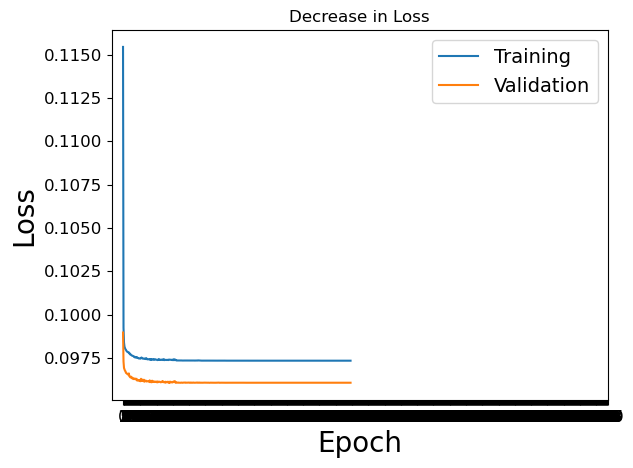

In [196]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
#ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [197]:
# compare autoencoder model to encoder and decoder models

f1 = autoencoder.predict(x_test)
f2 = decoder(encoder(x_test)[2])

63/63 [==============================] - 0s 1ms/step


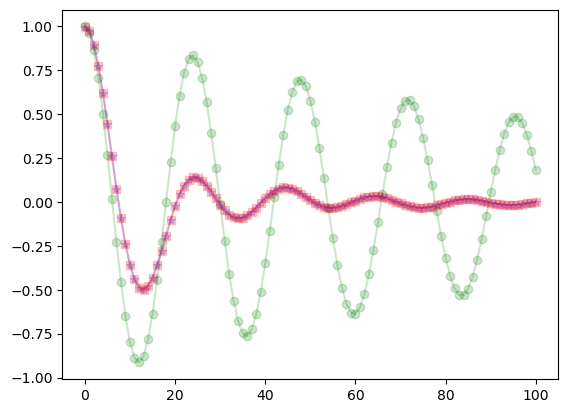

In [198]:
sample = 20

plt.plot(x_test[sample], color='g', marker='o', alpha=0.2)
plt.plot(f1[sample], color='b', marker='*', alpha=0.2)
plt.plot(f2[sample], color='r', marker='s', alpha=0.2)

In [199]:
encoded_data = encoder.predict(x_test)[2]

63/63 [==============================] - 0s 1ms/step


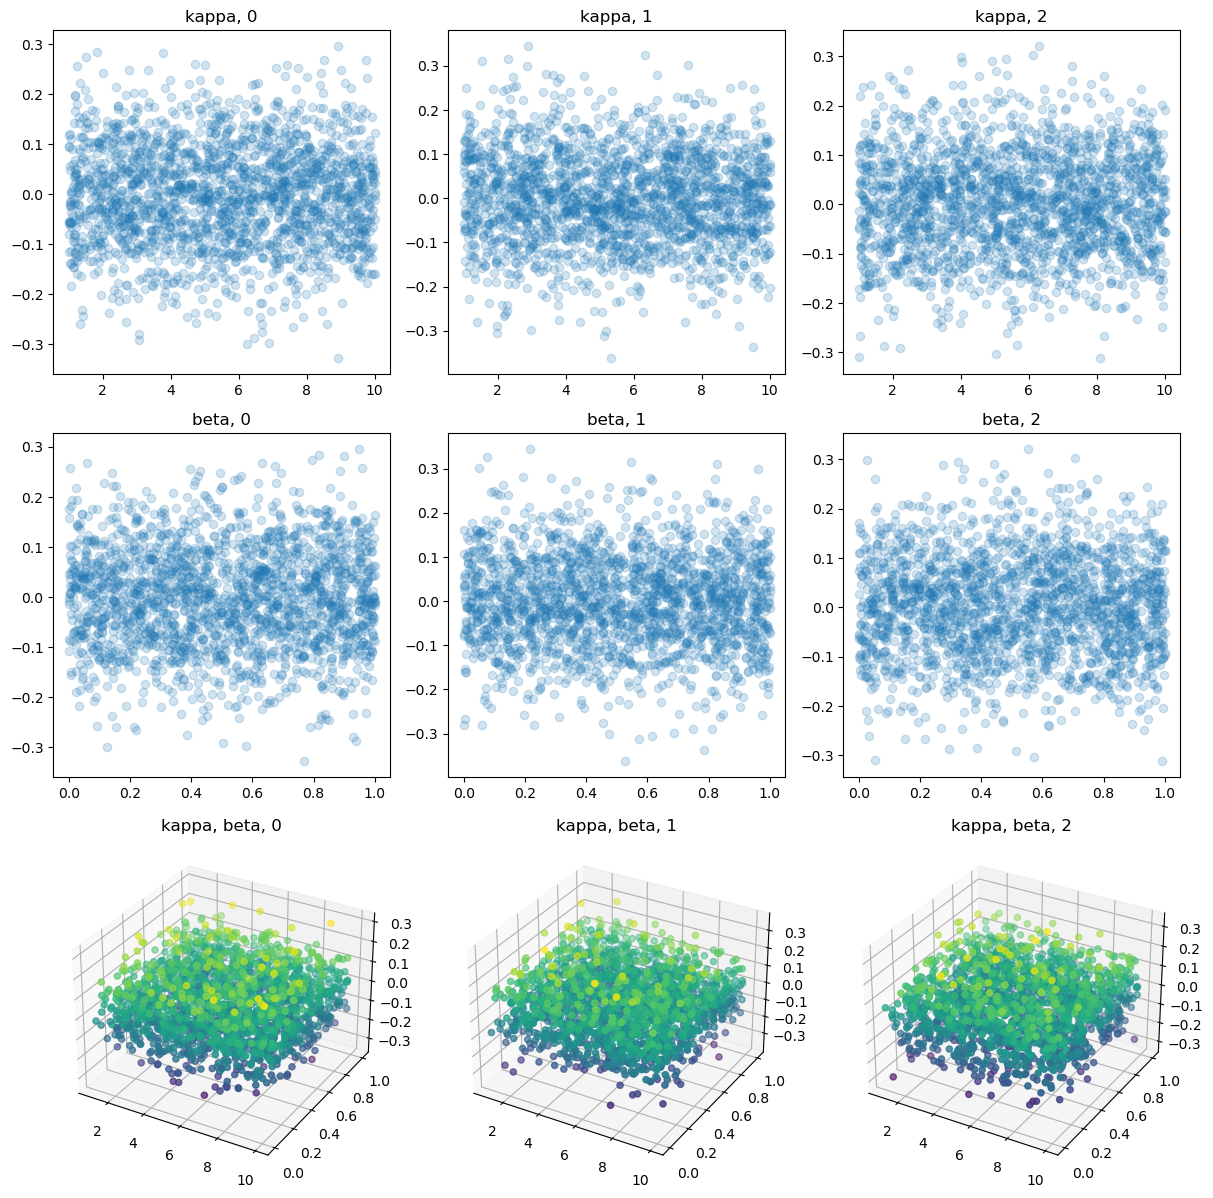

In [200]:
graphs = 'graphs_for_report'
save_path = f"VAE_b:{batch_size}_lr:{learning_rate}_r:{regul}_r2:{regul2}"

fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(331)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_title('kappa, 0')

ax2 = fig.add_subplot(334)
ax2.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax2.set_title('beta, 0')

ax3 = fig.add_subplot(332)
ax3.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax3.set_title('kappa, 1')

ax4 = fig.add_subplot(335)
ax4.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax4.set_title('beta, 1')

ax5 = fig.add_subplot(333)
ax5.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax5.set_title('kappa, 2')

ax6 = fig.add_subplot(336)
ax6.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax6.set_title('beta, 2')

ax7 = fig.add_subplot(337, projection='3d')
ax7.scatter(kappas_te, betas_te, encoded_data[:, 0], c=encoded_data[:, 0])
ax7.set_title('kappa, beta, 0')

ax8 = fig.add_subplot(338, projection='3d')
ax8.scatter(kappas_te, betas_te, encoded_data[:, 1], c=encoded_data[:, 1])
ax8.set_title('kappa, beta, 1')

ax9 = fig.add_subplot(339, projection='3d')
ax9.scatter(kappas_te, betas_te, encoded_data[:, 2], c=encoded_data[:, 2])
ax9.set_title('kappa, beta, 2')

plt.tight_layout()
graphs_file_path = os.path.join(graphs, save_path)
plt.savefig(os.path.join(f"{graphs_file_path}.png"))
plt.show()
plt.close(fig)